In [1]:
import pandas as pd
!pip install googletrans==4.0.0-rc1
from googletrans import Translator


In [2]:
import pandas as pd
import re
from datetime import datetime, timedelta

# Current date (system date: April 11, 2025)
current_date = datetime(2025, 4, 11)

# Load the data (assuming it's in a CSV file or directly as a DataFrame)
data = pd.read_csv("Private_dba_bike_listings.csv")  # Replace with your file path if needed
print("Initial Data Preview:")
print(data.head())

Initial Data Preview:
                                               Title       Price     Location  \
0                                  El - cykel unisex   8.000 kr.         Køge   
1  BMC Time Machine TM01 Triathlon Racer cykel, t...  13.500 kr.      Kolding   
2  (ALT SKAL VÆK) (BILLIGT) Kildemoes City, 7Gear...   1.799 kr.  København N   
3   (BILLIGT) Batavus City, 7Gears, sort Herre cykel   2.100 kr.  København N   
4   (BILLIGT) Raleigh City, 7Gears, Sort Herre cykel   1.999 kr.  København N   

           Time Posted Seller Type  
0         8. apr. 2025      Privat  
1  otte minutter siden      Privat  
2       to timer siden  RMS CYKLER  
3       to timer siden  RMS CYKLER  
4       to timer siden  RMS CYKLER  


In [3]:
# Clean the Price column
def clean_price(price):
    try:
        cleaned = str(price).replace(' kr.', '').replace('.', '').replace(',', '.')
        return float(cleaned)
    except:
        return None  # Return None if conversion fails

# Apply cleaning
data['Price'] = data['Price'].apply(clean_price)

# Drop rows where Price is None or NaN
data = data.dropna(subset=['Price'])

# Convert DKK to USD (1 DKK = 0.145 USD)
exchange_rate = 0.145
data['Price'] = data['Price'] * exchange_rate

# Preview cleaned price column
print("Cleaned and Converted Price (USD):")
print(data[['Price']].head())

Cleaned and Converted Price (USD):
      Price
0  1160.000
1  1957.500
2   260.855
3   304.500
4   289.855


In [38]:
# from googletrans import Translator

# # Initialize the translator
# translator = Translator()

# # Function to translate text
# def translate_text(text):
#     try:
#         return translator.translate(text, src='da', dest='en').text
#     except Exception:
#         return text  # If translation fails, return original text

# # Apply translation directly to the existing columns
# # data['Title'] = data['Title'].apply(translate_text)
# # data['Location'] = data['Location'].apply(translate_text)
# # data['Seller Type'] = data['Seller Type'].apply(translate_text)
# # # Translate 'Time Posted' column
# # data['Time Posted'] = data['Time Posted'].apply(translate_text)


# data = data[data['Seller Type'].str.lower() != 'rms bikes']

# # Check updated columns
# print(data[['Title', 'Location', 'Seller Type']].head())

# output_file = "fully_preprocessed_bike_listings.csv"
# data.to_csv(output_file, index=False)
# print(f"Preprocessed data saved to '{output_file}'")

# # Final Preview
# print("Preprocessed Data Preview:")
# print(data)

                                                Title       Location  \
0                                 EL - Bicycle unisex           Køge   
1   BMC TIME MACHINE TM01 TRIATHLON racing bike, t...        Kolding   
25  EL Bike Batavus Genova EGO COMFORT. Aar 2020 5...       Aabenraa   
31       Men's bike with lock and basket magnet lamps  Copenhagen NV   
32                   Christiania bike let with 7 gear          Valby   

     Seller Type  
0        Private  
1        Private  
25       Private  
31  Marry Cykler  
32       Private  
Preprocessed data saved to 'fully_preprocessed_bike_listings.csv'
Preprocessed Data Preview:
                                                 Title     Price  \
0                                  EL - Bicycle unisex  1160.000   
1    BMC TIME MACHINE TM01 TRIATHLON racing bike, t...  1957.500   
25   EL Bike Batavus Genova EGO COMFORT. Aar 2020 5...   579.855   
31        Men's bike with lock and basket magnet lamps   318.855   
32                  

In [16]:
empty_time_count = data['Price'].isna().sum() + (data['Price'] == '').sum()
print(f"Empty 'Time Posted' entries (NaN + empty strings): {empty_time_count}")


Empty 'Time Posted' entries (NaN + empty strings): 0


In [21]:
# See the rows that are flagged as exact duplicates
duplicates = data[data.duplicated(keep=False)]

# Show a few samples to inspect
print(duplicates.sample(10, random_state=1))


                                                 Title    Price  \
249  Trek.Men's bike, men's bike, frame 57 cm, fram...  224.750   
425  Centurion bike in really good condition.Frame ...  362.500   
95                New 28 ”Men's bike from Winora, 52cm  362.500   
473        Offers NEXTER TOKYO Lightweight bike 3 gear  478.355   
195                Kildemoes bike in purple.24 inches.  362.500   
297  Men's bike, Mustang Touring, Electric Bike, 8 ...  870.000   
431                           Retro bike from Peugeot!  870.000   
415        Bicycle clothing, winter bike jacket, assos  232.000   
390                                            Bicycle  289.855   
512                               Batavus Lord Bicycle  435.000   

          Location     Time Posted  Seller Type  
249       Hvidovre   two hours ago      Private  
425          Valby  three days ago      Private  
95    Copenhagen n  three days ago      Private  
473   Copenhagen Ø  four hours ago  Sali's Bike  
195        R

In [37]:
import re
from datetime import datetime, timedelta

# Helper to convert word numbers to integers
def word_to_number(word):
    word = word.lower()
    word_dict = {
        'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5,
        'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
        'a': 1, 'an': 1
    }
    return word_dict.get(word, 0)

# Function to convert "Time Posted" into datetime
def convert_time_posted(time_str, reference_time=None):
    if reference_time is None:
        reference_time = datetime.now().replace(microsecond=0)

    time_str = str(time_str).strip().lower()

    # Minutes ago
    minutes_match = re.match(r'(\w+)\s+minutes?\s+ago', time_str)
    if minutes_match:
        minutes = word_to_number(minutes_match.group(1))
        return (reference_time - timedelta(minutes=minutes)).replace(microsecond=0)

    # Hours ago
    hours_match = re.match(r'(\w+)\s+hours?\s+ago', time_str)
    if hours_match:
        hours = word_to_number(hours_match.group(1))
        return (reference_time - timedelta(hours=hours)).replace(microsecond=0)

    # Specific match for "an hour ago"
    if 'an hour ago' in time_str:
        return (reference_time - timedelta(hours=1)).replace(microsecond=0)

    # Days ago (handles both "day ago" and "days ago")
    days_match = re.match(r'(\w+)\s+days?\s+ago', time_str)
    if days_match:
        days = word_to_number(days_match.group(1))
        return (reference_time - timedelta(days=days)).replace(microsecond=0)

    if 'a day ago' in time_str:
        return (reference_time - timedelta(days=1)).replace(microsecond=0)

    # Absolute date like "Apr 82025" or "Apr. 82025"
    date_match = re.match(r'([a-zA-Z]{3})\.?\s*(\d{1,2})(\d{4})$', time_str)
    if date_match:
        month, day, year = date_match.groups()
        try:
            return datetime.strptime(f"{month} {day} {year}", "%b %d %Y").replace(microsecond=0)
        except ValueError:
            return None

    return None  # If nothing matches

# Apply parsing to your dataset
data['Parsed Time'] = data['Time Posted'].apply(convert_time_posted)

# Preview
print("Parsed Posting Time:")
print(data[['Time Posted', 'Parsed Time']].tail(60))

output_file = "fully_preprocessed_bike_listings.csv"
data.to_csv(output_file, index=False)
print(f"Preprocessed data saved to '{output_file}'")

Parsed Posting Time:
        Time Posted         Parsed Time
696    15 hours ago 2025-04-12 02:28:24
697    16 hours ago 2025-04-12 02:28:24
698    16 hours ago 2025-04-12 02:28:24
699    19 hours ago 2025-04-12 02:28:24
700    17 hours ago 2025-04-12 02:28:24
701   two hours ago 2025-04-12 00:28:24
702      6 Apr.2025                 NaT
703   two hours ago 2025-04-12 00:28:24
704   two hours ago 2025-04-12 00:28:24
705  four hours ago 2025-04-11 22:28:24
706  five hours ago 2025-04-11 21:28:24
707  five hours ago 2025-04-11 21:28:24
708    19 hours ago 2025-04-12 02:28:24
709   two hours ago 2025-04-12 00:28:24
710    18 hours ago 2025-04-12 02:28:24
711    18 hours ago 2025-04-12 02:28:24
712    19 hours ago 2025-04-12 02:28:24
713    19 hours ago 2025-04-12 02:28:24
714       A day ago 2025-04-11 02:28:24
715       A day ago 2025-04-11 02:28:24
716       A day ago 2025-04-11 02:28:24
717       A day ago 2025-04-11 02:28:24
718    18 hours ago 2025-04-12 02:28:24
719    21 hours ago

In [2]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("fully_preprocessed_bike_listings.csv")

df = df[df['Seller Type'].isin(['private', 'Private'])]

# Remove all empty rows
df = df.replace('', pd.NA).dropna(subset=['Price'])
df = df.dropna(subset=['Price'])

# Save the updated DataFrame to a new CSV file
df.to_csv("fully_preprocessed_bike_listings.csv", index=False)


In [5]:
empty_or_blank_count = df["Time Posted"].isna().sum() + (df["Time Posted"] == "").sum()
print(f"Number of empty or blank cells in 'Time Posted': {empty_or_blank_count}")


Number of empty or blank cells in 'Time Posted': 8


In [6]:
df = df[(df["Time Posted"].notna()) & (df["Time Posted"] != "")]


In [7]:
df.to_csv("fully_preprocessed_bike_listings.csv", index=False)


In [8]:
empty_or_blank_count = df["Seller Type"].isna().sum() + (df["Seller Type"] == "").sum()
print(f"Number of empty or blank cells in 'Seller Type': {empty_or_blank_count}")

Number of empty or blank cells in 'Seller Type': 0


In [9]:
empty_or_blank_count = df["Location"].isna().sum() + (df["Location"] == "").sum()
print(f"Number of empty or blank cells in 'Location': {empty_or_blank_count}")

Number of empty or blank cells in 'Location': 0


In [10]:
empty_or_blank_count = df["Price"].isna().sum() + (df["Price"] == "").sum()
print(f"Number of empty or blank cells in 'Price': {empty_or_blank_count}")

Number of empty or blank cells in 'Price': 0


In [11]:
empty_or_blank_count = df["Title"].isna().sum() + (df["Title"] == "").sum()
print(f"Number of empty or blank cells in 'Title': {empty_or_blank_count}")

Number of empty or blank cells in 'Title': 0


Top 10 Locations by Number of Listings:
Location
Valby              91
Hvidovre           29
Copenhagen N       28
Copenhagen K       28
Copenhagen Sv      28
Glostrup           28
Copenhagen S       22
Hellerup           15
Copenhagen Ø       14
Brønshøj           14
Copenhagen V       14
Brøndby            14
Smørum             14
Åbyhøj             14
Ringsted           14
Søborg             14
Aabenraa           14
Køge                8
Kastrup             7
Gentofte            7
Frederiksberg C     7
Rødovre             7
Vanløse             7
Frederiksberg       7
Værløse             7
Greve               7
Brøndby Strand      7
Skovlunde           7
Kolding             7
Lystrup             7
Odense V            7
Odense Lake         7
Aarhus C            7
Slagelse            7
Odense C            7
Sydals              1
Taastrup            1
Name: count, dtype: int64


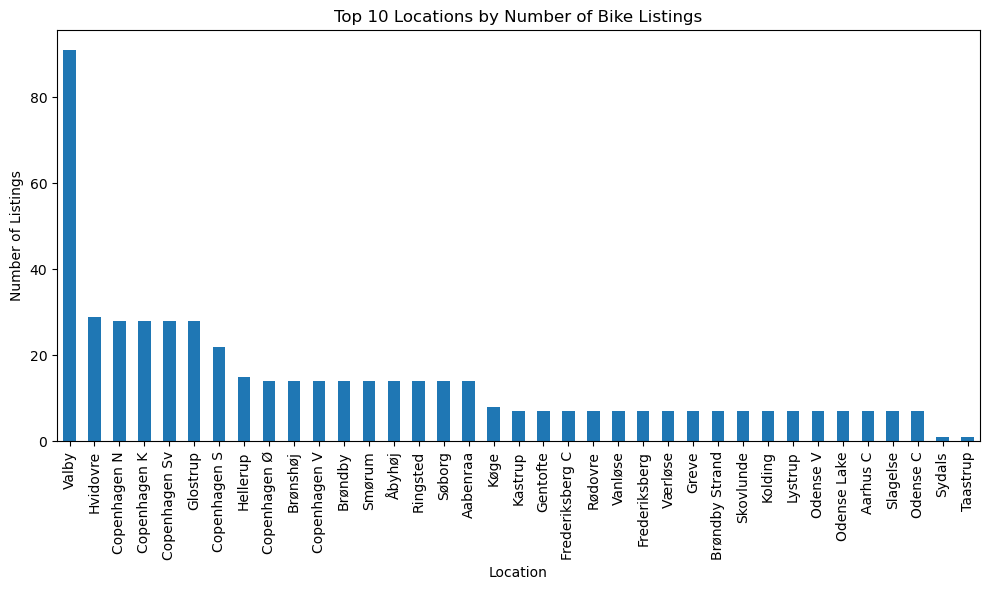

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset into a pandas DataFrame
df = pd.read_csv('fully_preprocessed_bike_listings.csv')  # Replace 'your_dataset.csv' with your file name

# Standardize location names
df['Location'] = df['Location'].str.strip().str.title().str.replace('.', '')  # Removes dots and standardizes case

# Count the number of listings per location
location_counts = df['Location'].value_counts()

# Display the top 10 locations
print("Top 10 Locations by Number of Listings:")
print(location_counts.head(46))

# Visualize the top 10 locations
location_counts.head(46).plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 Locations by Number of Bike Listings')
plt.xlabel('Location')
plt.ylabel('Number of Listings')
plt.tight_layout()
plt.show()

Average Price by Bike Type:
Bike Type
Other       660.778299
Racing      855.500000
Electric    975.931727
Name: Price, dtype: float64


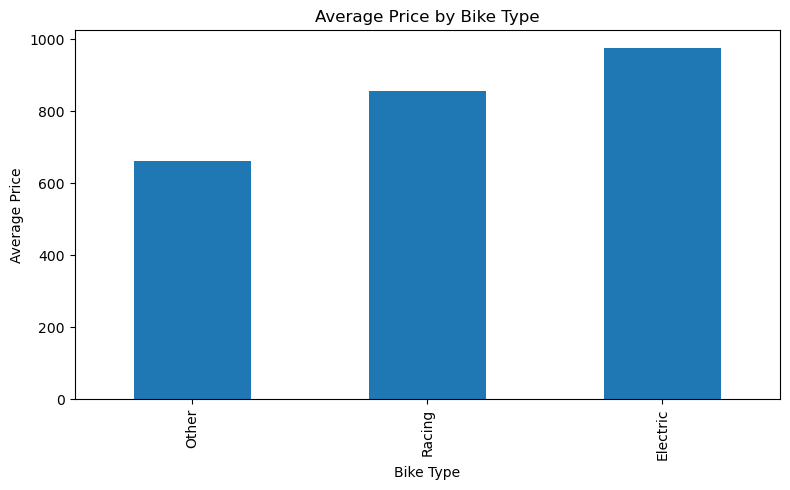

In [5]:
# Define keywords for bike types
electric_keywords = ['el', 'electric', 'ebike']
racing_keywords = ['racing', 'triathlon', 'speed']
mountain_keywords = ['mtb', 'mountain', 'gravel']

# Function to categorize bikes based on title
def categorize_bike(title):
    title_lower = title.lower()
    if any(keyword in title_lower for keyword in electric_keywords):
        return 'Electric'
    elif any(keyword in title_lower for keyword in racing_keywords):
        return 'Racing'
    elif any(keyword in title_lower for keyword in mountain_keywords):
        return 'Mountain'
    else:
        return 'Other'

# Add a new column for bike type
df['Bike Type'] = df['Title'].apply(categorize_bike)

# Calculate average price by bike type
avg_price_by_type = df.groupby('Bike Type')['Price'].mean().sort_values()

# Display the results
print("Average Price by Bike Type:")
print(avg_price_by_type)

# Visualize the average prices
avg_price_by_type.plot(kind='bar', figsize=(8, 5))
plt.title('Average Price by Bike Type')
plt.xlabel('Bike Type')
plt.ylabel('Average Price')
plt.tight_layout()
plt.show()

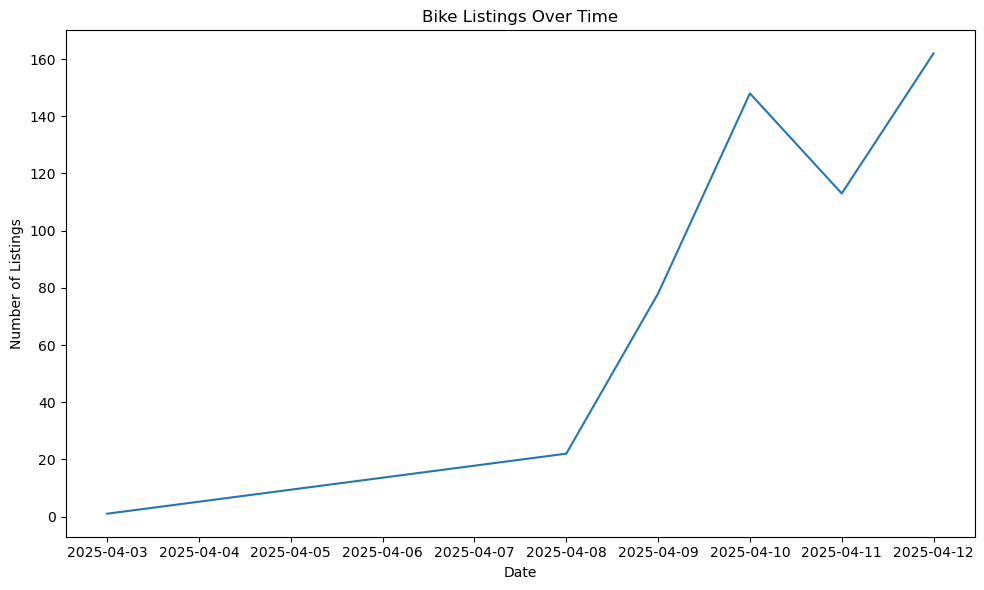

In [6]:
# Convert 'Time Posted' to datetime
df['Time Posted'] = pd.to_datetime(df['Time Posted'])

# Extract date (without time) for daily trends
df['Date'] = df['Time Posted'].dt.date

# Count listings per day
daily_listings = df.groupby('Date').size()

# Plot the trend
daily_listings.plot(kind='line', figsize=(10, 6))
plt.title('Bike Listings Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Listings')
plt.tight_layout()
plt.show()

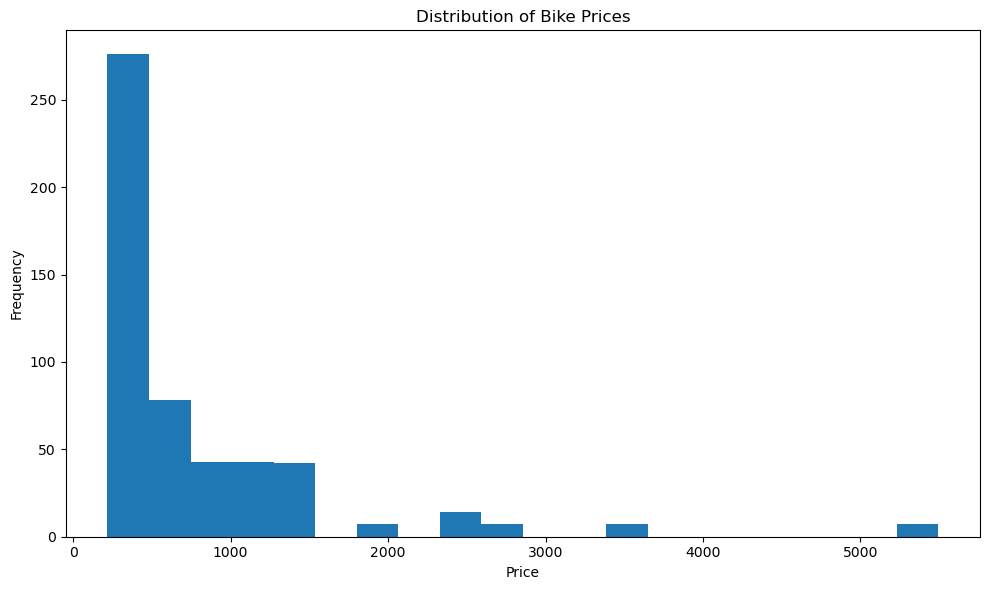

In [7]:
# Plot a histogram of prices
df['Price'].plot(kind='hist', bins=20, figsize=(10, 6))
plt.title('Distribution of Bike Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [8]:
# Count listings by seller type
seller_counts = df['Seller Type'].value_counts()
print("Listings by Seller Type:")
print(seller_counts)

# Average price by seller type
avg_price_by_seller = df.groupby('Seller Type')['Price'].mean()
print("Average Price by Seller Type:")
print(avg_price_by_seller)

Listings by Seller Type:
Seller Type
Private    524
Name: count, dtype: int64
Average Price by Seller Type:
Seller Type
Private    767.819275
Name: Price, dtype: float64
